In [1]:
from pathlib import Path
import gzip
import pickle

%matplotlib inline

In [2]:
#export
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

from functools import partial
import math
import re
import matplotlib.pyplot as plt

# Path and data

In [3]:
home_dir = Path('.').resolve()
data_dir = home_dir/'data'
file_dir = data_dir/'mnist.pkl.gz'

file_dir

PosixPath('/Users/xianli/Desktop/fast/Part2/data/mnist.pkl.gz')

In [4]:
# MNIST_url = 'http://deeplearning.net/data/mnist/mnist.pkl'

In [5]:
with gzip.open(file_dir, 'r') as f:
    (x_train, y_train), (x_valid, y_valid), _ = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

# Dataset and dataloader

In [6]:
#export
class myDataset():
    def __init__(self,x,y):
        self.x, self.y = x, y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self,i):
        return self.x[i], self.y[i]

In [7]:
#export
def get_dls(ds_train, ds_valid, bs, **kwargs):
    return DataLoader(ds_train, bs, shuffle=True, **kwargs), DataLoader(ds_valid, bs, shuffle=False, **kwargs)

In [8]:
ds_train, ds_valid = myDataset(x_train,y_train), myDataset(x_valid,y_valid)

In [9]:
bs = 64

In [10]:
#export
class DataBunch():
    def __init__(self, dl_train,dl_valid, c_out = None):
        self.dl_train = dl_train
        self.dl_valid = dl_valid
        self.c_out = c_out
    @property
    def train_ds(self):
        return self.dl_train.dataset
    @property
    def valid_ds(self):
        return self.dl_valid.dataset

In [11]:
data = DataBunch(*get_dls(ds_train,ds_valid, bs),c_out=10)

In [12]:
len(data.train_ds), len(data.valid_ds)

(50000, 10000)

# Model, loss and metric

In [30]:
#export
def get_model(data,lr=0.5,nh=50): # used the databunch from previous section
    fan_in = data.train_ds.x.shape[1] # this data is databunch
    model = nn.Sequential(nn.Linear(fan_in,nh), nn.ReLU(), nn.Linear(nh, data.c_out))
    return model, optim.SGD(model.parameters(),lr=lr)

In [14]:
loss_func = F.cross_entropy

In [15]:
#export
def accuracy(pred, targ):
    return (torch.argmax(pred, dim=1)==targ).float().mean()

# Minimal callback example

In [16]:
from time import sleep
class Slow_linear():
    def __init__(self, val, cb=None):
        self.val = val
        self.output = 0.
        self.cb = cb
        
    def __call__(self, cb_name, *args):
        if not self.cb: return
        f = getattr(self.cb, cb_name, None)
        if f:
            return f(self,*args)
    
    def repeat_n(self, n):
        for i in range(n):
            if self('before_each'): return
            self.output = self.val+i
            if self('after_each',i): break
            sleep(0.2)
            print(self.output)

                
class SquareCallback():
    def after_each(self, obj, i):
        if i >1:
            obj.output = obj.output**2
        if i >3:
            print('Early stopping')
            return True

In [17]:
original = Slow_linear(2)
original.repeat_n(5)

2
3
4
5
6


In [18]:
modified = Slow_linear(2, SquareCallback())
modified.repeat_n(5)

2
3
16
25
Early stopping


# Helper functions

In [19]:
#export
_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

In [20]:
# export
# helper function: standardize everything into lists
from typing import Iterable

def listify(inp):
    if inp is None: return []
    if isinstance(inp, list): return inp
    if isinstance(inp, Iterable): return list(inp)
    return [inp] 

# Better callback system and early stopping handler
- Problem in original version that uses if -> return: the exit is not complete or we'll have to break every single outside iterations to fully break out. --> Solution: use Exception to immediately jump out of the loops 

In [1]:
#export
# base class
class Callback():
    _order = 0
    def set_runner(self, runner):
        self.runner = runner # tells the callback who's calling them
        
    def __getattr__(self, key):
        return getattr(self.runner, key)
    
    def __call__(self, cb_name):
        # this call runs the callbacks
        f = getattr(self, cb_name, None) # return None if not found
        if f and f(): return True # means break
        return False # means normal and continue
    
    @property
    def name(self):
        name = re.sub(r'Callback$','', self.__class__.__name__)
        return camel2snake(name or 'callback')

### Required callback 1: switch between training and validation mode, as well as maintaining a count of the iterations, or the percentage of iterations elapsed in the epoch.

In [40]:
#export
#setting training and evaluation phases callback
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.runner.epochs_elp=0.
        self.runner.batch_elp = 0.
        
    def begin_epoch(self):
        self.runner.epochs_elp = self.ep
        self.model.train()
        self.runner.in_train = True
    
    def after_batch(self):
        if not self.in_train: return
        self.runner.epochs_elp += 1./self.num_batch
        self.runner.batch_elp +=1
    
    def begin_validation(self):
        self.model.eval()
        self.runner.in_train=False

- Define new exceptions that have the same behavior as default

In [41]:
#export
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass
class CancelTrainException(Exception): pass

In [44]:
#export
class Learner():
    _ALL_CBS = {'begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step',
        'after_cancel_batch', 'after_batch', 'after_cancel_epoch', 'begin_fit',
        'begin_epoch', 'begin_epoch', 'begin_validation', 'after_epoch',
        'after_cancel_train', 'after_fit'}  
    
    def __init__(self, model, opt, loss_func, data, cb_objs=None,cb_classes=None):
        self.model = model
        self.opt= opt
        self.loss_func = loss_func
        self.data = data
        
        cbs = listify(cb_objs)
        for cbf in listify(cb_classes):
            cb = cbf()
            setattr(self,cb.name,cb) # name set by base callback class
            cbs.append(cb)
        self.cbs = [TrainEvalCallback()] + cbs # always need the traineval callback
    
    def __call__(self, cb_name):
        res = False
        assert cb_name in self._ALL_CBS # sanity check
        for cb in sorted(self.cbs, key=lambda x:x._order):
            res = cb(cb_name) and res # ??? always return False???
        if res:
            print(f'res in Learner __call__ returns {res}!!')
        return res
    
    def one_batch(self,xb,yb):
        try:
            self.xb, self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally:
            self('after_batch')
    
    def all_batches(self,dl):
        self.num_batch = len(dl)
        try:
            for xb, yb in dl:
                self.one_batch(xb, yb)
        except CancelEpochException: 
            self('after_cancel_epoch')
    
    def fit(self, epochs):
        self.epochs = epochs
        try:
            for cb in self.cbs: cb.set_runner(self)
  
            self('begin_fit')
            for ep in range(epochs):
                self.ep = ep
                if not self('begin_epoch'):
                    self.all_batches(self.data.dl_train)
                # validate in each epoch
                with torch.no_grad():
                    if not self('begin_validation'):
                        self.all_batches(self.data.dl_valid)
                self('after_epoch')
        except CancelTrainException: self('after_cancel_train')
        finally: 
            self('after_fit')             

In [45]:
learner = Learner(*get_model(data), loss_func, data)
learner.fit(5)

### optional callback 1: printing metrics

In [46]:
#export
class AvgStats(): # general class for all kinds of stats
    def __init__(self, metrics, in_train):
        self.metrics = listify(metrics)
        self.in_train = in_train
    def reset(self):
        self.tot_loss = 0.
        self.count = 0
        self.tot_mets = [0.] *len(self.metrics)
    
    @property
    def all_stats(self):
        return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self):
        return [st/self.count for st in self.all_stats]
    @property
    def metric_names(self):
        return ['loss'] + [met.__name__ for met in self.metrics]
    
    def __repr__(self):
        if not self.count: return ''
        return f"{'train' if self.in_train else 'valid'}: {[(name + ' = ' + str(st)) for name, st in zip(self.metric_names, self.avg_stats)]}"
    
    def accumulate(self, runner):
        # accumulate loss
        batch_size = runner.xb.shape[0]
        self.tot_loss += runner.loss * batch_size # CrossEntropyLoss was averaged
        self.count += batch_size
        # accumulate metrics
        for i, m in enumerate(self.metrics): # if the name doesn't agree, add an property
            self.tot_mets[i] += m(runner.pred, runner.yb) * batch_size # assume averaged metric value

class AvgStatsCallback(Callback): # define when AvgStats is used and how it's used in various phases of training
    def __init__(self, metrics): 
        self.train_stats = AvgStats(metrics,True)
        self.valid_stats = AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
    
    def after_loss(self):
        stat = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad():
            stat.accumulate(self.runner)
    def after_epoch(self):
        print(self.train_stats) # call __repr__
        print(self.valid_stats)
    

In [47]:
cb_obj = [AvgStatsCallback([accuracy])]
learner = Learner(*get_model(data), loss_func, data, cb_obj)
learner.fit(5)

train: ['loss = 0.31626896484375', 'accuracy = tensor(0.9029)']
valid: ['loss = 0.16654102783203126', 'accuracy = tensor(0.9491)']
train: ['loss = 0.14228103515625', 'accuracy = tensor(0.9565)']
valid: ['loss = 0.12325469970703125', 'accuracy = tensor(0.9633)']
train: ['loss = 0.104723193359375', 'accuracy = tensor(0.9682)']
valid: ['loss = 0.261717236328125', 'accuracy = tensor(0.9364)']
train: ['loss = 0.086741552734375', 'accuracy = tensor(0.9731)']
valid: ['loss = 0.10051858520507813', 'accuracy = tensor(0.9703)']
train: ['loss = 0.0725842626953125', 'accuracy = tensor(0.9771)']
valid: ['loss = 0.19067257080078126', 'accuracy = tensor(0.9524)']


### optional callback 2: run a few iterations for testing

In [63]:
#export
class TestRunCallback(Callback):
    _order = 100 # run last
    def __init__(self, n, print_loss=False, plot_loss=True):
        self.n = n # run n iterations
        self.save_losses = []
        self.count = 0
        self.print_loss, self.plot_loss = print_loss, plot_loss
    
    def reset(self):
        self.count = 0
        self.save_losses = []
        
    def after_batch(self):
        self.count += 1
        self.save_losses.append(self.loss) # Callback class will find self.loss
        if self.count > self.n:
            raise CancelTrainException()
        if self.print_loss:
            print(f'Completed batch #{self.count}, loss = {self.loss}')
        
    def after_fit(self):
        if self.plot_loss:
            plt.subplot()
            plt.plot(self.save_losses)
            plt.xlabel('Number of batches trained')
            plt.ylabel('Loss')
        self.reset()

Completed batch #1, loss = 2.2948713302612305
Completed batch #2, loss = 2.2112996578216553
Completed batch #3, loss = 2.1371114253997803
Completed batch #4, loss = 2.098545551300049
Completed batch #5, loss = 2.0053117275238037
Completed batch #6, loss = 1.88539457321167
Completed batch #7, loss = 1.707342505455017
Completed batch #8, loss = 1.6761274337768555
Completed batch #9, loss = 1.519668459892273
Completed batch #10, loss = 1.3675857782363892


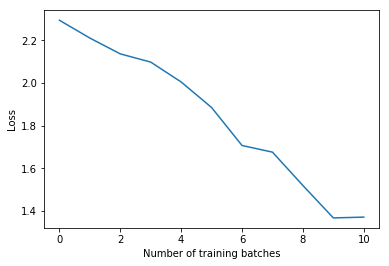

In [64]:
cb_objs = [AvgStatsCallback([accuracy]), TestRunCallback(10,True)]
learner = Learner(*get_model(data), loss_func, data, cb_objs)
learner.fit(5)

### Optional callback 3: record loss and learning rate during training

In [126]:
#export
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []
    
    def after_batch(self):
        if not self.in_train: return
        for pg, lr in zip(self.opt.param_groups, self.lrs):
            lr.append(pg['lr']) # learning rate for each param group
        self.losses.append(self.loss.detach().cpu())
    
    def plot_lr(self, pgid = -1):
        plt.plot(self.lrs[pgid])

    def plot_loss(self, skip_last=0):
        plt.subplot()
        plt.plot(self.losses[:len(self.losses)-skip_last])
        plt.xlabel('Number of batches trained')
        plt.ylabel('Loss')
    
    # this is designed for LR_finder
    def plot(self, skip_last=0,pgid=-1): # plot lr vs losses
        losses = [o.item() for o in self.losses]
        lrs = self.lrs[pgid]
        n = len(losses) - skip_last
        plt.xscale('log')
        plt.plot(lrs[:n],losses[:n])
        plt.xlabel('Learning rate')
        plt.ylabel('Loss')
        

In [69]:
# # pass callbacks as objects
# cb_objs = [Recorder(), AvgStatsCallback([accuracy])]
# learner = Learner(*get_model(data), loss_func, data, cb_objs)

# pass callbacks as functions
cb_funcs = [Recorder, partial(AvgStatsCallback, accuracy)]
learner = Learner(*get_model(data), loss_func, data, cb_classes=cb_funcs)
learner.fit(5)

train: ['loss = 0.31133986328125', 'accuracy = tensor(0.9036)']
valid: ['loss = 0.563991796875', 'accuracy = tensor(0.8603)']
train: ['loss = 0.138580576171875', 'accuracy = tensor(0.9580)']
valid: ['loss = 0.2642146240234375', 'accuracy = tensor(0.9149)']
train: ['loss = 0.10548115234375', 'accuracy = tensor(0.9681)']
valid: ['loss = 0.09866235961914062', 'accuracy = tensor(0.9711)']
train: ['loss = 0.08519353515625', 'accuracy = tensor(0.9734)']
valid: ['loss = 0.106950927734375', 'accuracy = tensor(0.9697)']
train: ['loss = 0.0727147998046875', 'accuracy = tensor(0.9773)']
valid: ['loss = 0.09800508422851563', 'accuracy = tensor(0.9733)']


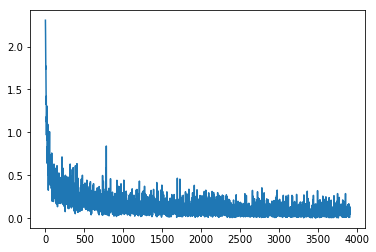

In [73]:
learner.recorder.plot_loss()

### optional callback 4: Parameter Scheduler (e.g. one-cycle fit)

In [93]:
#export
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_funcs):
        self.pname, self.sched_funcs = pname, sched_funcs
    
    def begin_fit(self):
        if not isinstance(self.sched_funcs,(list,tuple)): # i.e. it's a single function 
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups) # one scheduler for each param_group
    
    def set_param(self):
        assert len(self.opt.param_groups) == len(self.sched_funcs)
        for pg, f in zip(self.opt.param_groups, self.sched_funcs):
            pg[self.pname] = f(self.epochs_elp/self.epochs) # this argument is percent progress
    
    def begin_batch(self):
        if self.in_train: self.set_param()

In [94]:
#export
# annealer
def annealer(f):
    def _inner(st,en): return partial(f,st,en)
    return _inner

In [103]:
#export
# schedule functions
@annealer
def sched_lin(start, end, pos): return start+pos*(end-start)
@annealer
def sched_exp(start, end, pos): return start*(end/start)**pos
@annealer
def sched_cos(start, end, pos): return start + (1+math.cos(math.pi*(1-pos)))*(end-start)/2

In [104]:
#export
# combine schedules and return combined FUNCTION
def combine_scheds(pcts, scheds):
    assert len(pcts) == len(scheds)
    assert sum(pcts) == 1
    pcts = torch.tensor([0]+listify(pcts))
    assert torch.all(pcts>=0)
    pcts = torch.cumsum(pcts, dim=0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max() # index of the current schedule function to use
        actual_pos =  (pos - pcts[idx])/(pcts[idx+1] - pcts[idx]) # percent pos wrt current schedule
        return scheds[idx](actual_pos)
    return _inner

In [105]:
# just a test
pct = torch.tensor([0, 0.1,0.4,1.])
pos = 0.5
(pos>pct)

tensor([1, 1, 1, 0], dtype=torch.uint8)

train: ['loss = 0.358206015625', 'accuracy = tensor(0.8925)']
valid: ['loss = 0.24264287109375', 'accuracy = tensor(0.9279)']
train: ['loss = 0.17042142578125', 'accuracy = tensor(0.9486)']
valid: ['loss = 0.13117052001953125', 'accuracy = tensor(0.9600)']


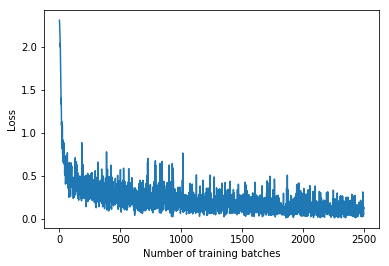

In [116]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3,0.6), sched_cos(0.6,0.2)])

cb_funcs = [Recorder, 
            partial(ParamScheduler,'lr',sched), 
            partial(AvgStatsCallback, accuracy),
            partial(TestRunCallback,2500)]
learner = Learner(*get_model(data), loss_func, data, cb_classes=cb_funcs)
learner.fit(5)

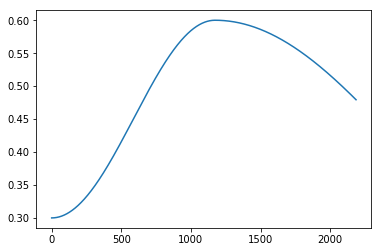

In [117]:
learner.recorder.plot_lr()

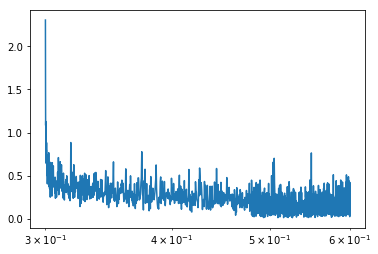

In [119]:
learner.recorder.plot()

### optional callback 5: LR_Finder

In [127]:
#export
class LR_Finder(Callback):
    _order = 1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr = 10, thres=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss=1e9
        self.thres = thres # if loss > thres * best_loss: stop 
        
    def begin_batch(self):
        if not self.in_train: return
        pos = self.batch_elp / self.max_iter # self.batch_elp is set by TrainEvalCallback and added to Learner as an attribute
        lr = self.min_lr * (self.max_lr/self.min_lr) ** pos # exponentially grow from min_lr to max_lr
        for pg in self.opt.param_groups: 
            pg['lr'] = lr # set all parameter group lrs
            
    def after_step(self): # stop critera
        # stop if iterations exceed max_iter or loss is much worse than the best loss so far
        if self.batch_elp >= self.max_iter or self.loss > self.thres*self.best_loss:
            raise CancelTrainException()
        if self.loss < self.best_loss:
            self.best_loss = self.loss # this self.loss is fetched by Callback base class from Learner        

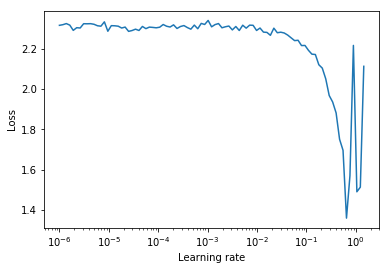

In [132]:
lr_find_cbf = [Recorder, LR_Finder]
lrfind_obj = Learner(*get_model(data), loss_func, data, cb_classes=lr_find_cbf)
lrfind_obj.fit(2)
lrfind_obj.recorder.plot(skip_last=3)

In [139]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3,0.5), sched_cos(0.5,0.1)])

cb_funcs = [Recorder, 
            partial(ParamScheduler,'lr',sched), 
            partial(AvgStatsCallback, accuracy)]
# cb_funcs += [partial(TestRunCallback,200)] # use for testing (i.e. run only a few batches)
learner = Learner(*get_model(data), loss_func, data, cb_classes=cb_funcs)
learner.fit(5)

train: ['loss = 0.352866171875', 'accuracy = tensor(0.8942)']
valid: ['loss = 0.2200463623046875', 'accuracy = tensor(0.9327)']
train: ['loss = 0.166138515625', 'accuracy = tensor(0.9507)']
valid: ['loss = 0.122131005859375', 'accuracy = tensor(0.9640)']
train: ['loss = 0.111979462890625', 'accuracy = tensor(0.9668)']
valid: ['loss = 0.10519422607421874', 'accuracy = tensor(0.9685)']
train: ['loss = 0.0794440234375', 'accuracy = tensor(0.9765)']
valid: ['loss = 0.09132735595703124', 'accuracy = tensor(0.9722)']
train: ['loss = 0.0614870849609375', 'accuracy = tensor(0.9821)']
valid: ['loss = 0.08723295288085937', 'accuracy = tensor(0.9727)']


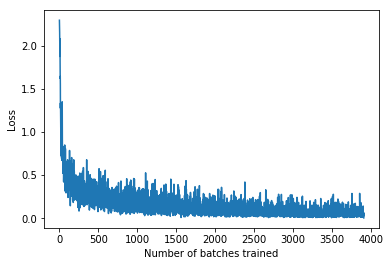

In [141]:
learner.recorder.plot_loss()

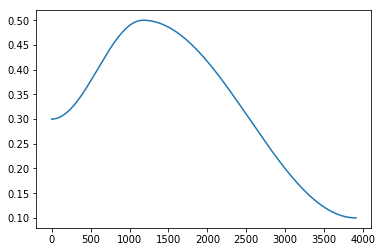

In [142]:
learner.recorder.plot_lr()

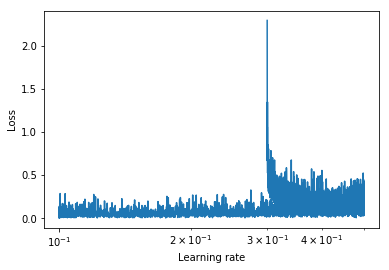

In [143]:
learner.recorder.plot()

- optional callback 6: save parameters

# Export

In [3]:
!./notebook2script.py Earlystop_LRfinder_Lesson4.ipynb

Converted Earlystop_LRfinder_Lesson4.ipynb to exp/nb_Earlystop.py
